(7, 8)
output: tensor([[ 8.4355e-01, -1.3156e+00,  3.4579e-02,  4.9556e-01,  7.1419e-01,
          1.5411e+00,  7.8249e-01, -8.6090e-01,  1.3445e+00, -1.1543e+00,
         -1.5221e+00,  9.5772e-01, -2.4076e+00, -3.2958e-02, -3.8371e-01,
          2.1279e+00],
        [ 1.4366e+00, -1.5224e-03,  9.2057e-01,  7.7569e-02,  9.8650e-01,
          4.1973e-01, -9.2611e-01,  1.3938e+00, -2.6703e+00,  8.9811e-01,
         -4.5093e-01, -1.4467e+00, -2.3132e+00,  1.8184e+00,  1.4665e+00,
          3.3041e-01],
        [-3.4601e-01, -6.6869e-01, -4.6731e-01,  1.0301e+00,  4.1693e-01,
          1.4157e-02, -2.4209e-01,  2.2169e-01,  2.2917e-01,  6.0059e-01,
          1.2184e+00, -2.1807e-01,  7.8177e-01, -5.5542e-01,  2.0487e+00,
          1.3726e+00],
        [-8.8901e-02, -4.2683e-01,  8.3267e-01, -7.6014e-01, -2.4974e-01,
         -7.2167e-02,  1.0954e+00,  5.3598e-01,  1.9197e-01, -2.0199e+00,
          6.4209e-01, -1.8491e-01, -1.2158e+00, -1.4674e-01, -2.4530e+00,
          1.5309e+00],
     

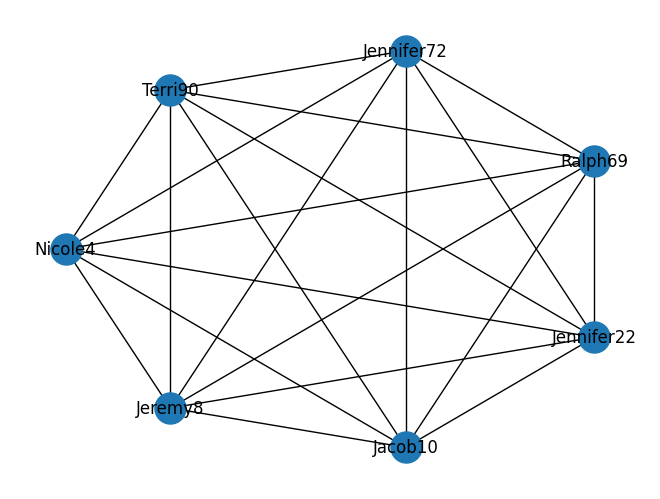

Compatibility Scores: 
Terri90 --> Jennifer72: 0.9720151084787803
Terri90 --> Ralph69: 0.946016463192387
Terri90 --> Jennifer22: 0.9321590107118287
Terri90 --> Jacob10: 0.9010258146453128
Terri90 --> Nicole4: 0.8230783144738791
Terri90 --> Jeremy8: 0.8003519461463624
nx.html


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import filter_dataset
from pyvis import network as net

df1 = pd.read_csv("R:/Git/Relator_Bot/test datasets/name_location.csv")
user_name = input("Enter user name: ")
#df1 = pd.read_csv("R:/Git/Relator_Bot/test datasets/1000_location.csv")
df = filter_dataset.filter_ds(user_name, df1)
print(df.shape)
torch.manual_seed(52)

def gcn_main():
    G = nx.Graph()
    label = {}
    likes = {}
    search = {}

    for i, (user, category) in enumerate(zip(df['first_name'], df['categories'])):
        label[i] = user  # Use index as node label
        search[user] = i
        G.add_node(i, title=user, label=user)
        likes[user] = category
        
    for u in range(len(label)):
        for v in range(len(label)):
            if u != v:
                categories1 = set(likes[label[u]].split(','))
                categories2 = set(likes[label[v]].split(','))
                common_categories = categories1.intersection(categories2)
                union_categories = categories1.union(categories2)
                similarity_score = float(len(common_categories) / len(union_categories)) * 100
                if common_categories:
                    G.add_edge(u, v, weight=similarity_score)

    if G.number_of_edges() == 0:
        print("Error: The graph has no edges.")
        return

    edges = list(G.edges())

    x = torch.randn(len(label), 16)
    print("output:",x)
    edge_index = torch.tensor(edges).t().contiguous()
    data = Data(x=x, edge_index=edge_index)

    gcn_model = GCNModel(input_dim=16, hidden_dim=32, output_dim=1)

    gcn_output = gcn_model(data)

    visualize_graph(G, label, search, gcn_output)

    # return gcn_output

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x 

def visualize_graph(G, label, search, gcn_output):
    pos = nx.shell_layout(G)
    nx.draw(G, pos, labels=label, with_labels=True, node_size=500)
    plt.draw()
    plt.show()
    
    # user_name = input("Enter user name: ")
    user_index = search.get(user_name)
    if user_index is not None:
        get_score(G, label, user_index, gcn_output, label)
    else:
        print("User not found.")

    nt = net.Network(notebook=True, cdn_resources='remote', height="900px", width="100%", bgcolor="#222222", font_color="white")
    nt.barnes_hut()
    nt.from_nx(G, default_node_size=100, show_edge_weights=True, edge_scaling=True)
    neighbor_map = nt.get_adj_list()
    
    for node in nt.nodes:
        neighbors = neighbor_map[node["id"]]
        neighbor_labels = "\n".join(label[i] for i in neighbors)
        node["title"] += " Neighbors: \n" + neighbor_labels
        node["value"] = len(neighbor_map[node["id"]])

    nt.prep_notebook()
    nt.show('nx.html')

def get_score(G, label, user_index, gcn_output, search):
    user_score = {}
    user_embedding = gcn_output[user_index].detach().numpy()
    for other_user_index in range(len(label)):
        if user_index != other_user_index:
            other_user_embedding = gcn_output[other_user_index].detach().numpy()
            similarity_score = float(
                1.0 / (1.0 + np.linalg.norm(user_embedding - other_user_embedding))  # Cosine similarity
            )
            user_score[other_user_index] = similarity_score

    print("Compatibility Scores: ")
    for user, score in sorted(user_score.items(), key=lambda x: x[1], reverse=True):
        print(f"{label[user_index]} --> {label[user]}: {score}")

gcn_main()
